In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
isInKaggle = False
ROOT = '/kaggle/input/' if isInKaggle else 'D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/'
for dirname, _, filenames in os.walk(ROOT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/.gitattributes
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/.gitignore
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/.Rbuildignore
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/.RData
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/.Rhistory
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/DESCRIPTION
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/NAMESPACE
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/prob_quedaAviao.html
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/RClasses/RClasses.Rproj
D:/OneDrive - Universidade Federal do Cariri - UFCA/Drive

# The test set and the number of steps ahead to forecast

In [2]:

DATA_PATH = ROOT + "godaddy-microbusiness-density-forecasting/" if isInKaggle else ROOT + "data/microbusinessDensityTS/"
RESULTS_PATH = "" if isInKaggle else ROOT + "results/microbusinessDensityTS/"
test = pd.read_csv(filepath_or_buffer = DATA_PATH+"test.csv")#, index_col='row_id')
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


Thus, we have to develop a model to perform 8-steps ahead forecasts per county...

In [3]:
test["first_day_of_month"].value_counts()#.shape

2022-11-01    3135
2022-12-01    3135
2023-01-01    3135
2023-02-01    3135
2023-03-01    3135
2023-04-01    3135
2023-05-01    3135
2023-06-01    3135
Name: first_day_of_month, dtype: int64

In [4]:
test["cfips"].value_counts()#.shape)

1001     8
39133    8
39089    8
39091    8
39093    8
        ..
21113    8
21115    8
21117    8
21119    8
56045    8
Name: cfips, Length: 3135, dtype: int64

# The training set and some characteristics

In [5]:
train = pd.read_csv(DATA_PATH + "train.csv")#, index_col='row_id')
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


The variables `county` and `state` and `row_id` are neglectable...

In [6]:
train.drop(['county', 'state', 'row_id'], inplace = True, axis = 1)
train.head()

,cfips,first_day_of_month,microbusiness_density,active
0,1001,2019-08-01,3.007682,1249
1,1001,2019-09-01,2.884870,1198
2,1001,2019-10-01,3.055843,1269
3,1001,2019-11-01,2.993233,1243
4,1001,2019-12-01,2.993233,1243


Each `first_day_of_month` value repeats the same number of times...

Similarly, each `cfips` value repeats the same number of times... 

In [7]:
dates = train['first_day_of_month'].value_counts()
cfipss = train['cfips'].value_counts()
# dates
cfipss

1001     39
39133    39
39089    39
39091    39
39093    39
         ..
21113    39
21115    39
21117    39
21119    39
56045    39
Name: cfips, Length: 3135, dtype: int64

In [8]:
print('Each date repeats', dates[0],'times. One per cfipss.')
print('Each cfips repeats', cfipss.values[0],'times. One per date. ')
print('Thus, one has', dates[0], 'time series, each one with', cfipss.values[0], 'observations...')

Each date repeats 3135 times. One per cfipss.
Each cfips repeats 39 times. One per date. 
Thus, one has 3135 time series, each one with 39 observations...


The training time series are therefore too small ... the state-of-the-art approaches must be rethinked...

There is no negative value. Thus, one can work with the logarithm tranrformation...

In [9]:
train.microbusiness_density.describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

### The time series indexes

In [10]:
# to make use in the time series modeling and forecasting...
def getCategories(varName, dataFrame):
    labels = dataFrame[varName].value_counts().reset_index(
            name='Freq').rename(columns={'index': varName}).sort_values(by=varName)
    labels = labels[varName].tolist()
    print("********** " + varName + " **********")
    print("length = ", len(labels))
    print(labels[:2], ' ... ', labels[len(labels)-2:])
    return(labels)
dates = getCategories('first_day_of_month', train)
testDates = getCategories('first_day_of_month', test)
cfipss = getCategories('cfips', train)#list(cfipss.index)
# cfipss[:5]

********** first_day_of_month **********
length =  39
['2019-08-01', '2019-09-01']  ...  ['2022-09-01', '2022-10-01']
********** first_day_of_month **********
length =  8
['2022-11-01', '2022-12-01']  ...  ['2023-05-01', '2023-06-01']
********** cfips **********
length =  3135
[1001, 1003]  ...  [56043, 56045]


In [11]:

train.set_index(keys = ['cfips', 'first_day_of_month'], inplace=True)#
train.sort_index(inplace=True)
train

microbusiness_density  active
cfips first_day_of_month                               
1001  2019-08-01                       3.007682    1249
      2019-09-01                       2.884870    1198
      2019-10-01                       3.055843    1269
      2019-11-01                       2.993233    1243
      2019-12-01                       2.993233    1243
...                                         ...     ...
56045 2022-06-01                       1.803249     101
      2022-07-01                       1.803249     101
      2022-08-01                       1.785395     100
      2022-09-01                       1.785395     100
      2022-10-01                       1.785395     100

[122265 rows x 2 columns]

In [12]:
print('The training set ends at', dates[len(dates)-1], 
      'in alignment with the beginning of the test set:', 
      test['first_day_of_month'][0])

The training set ends at 2022-10-01 in alignment with the beginning of the test set: 2022-11-01


## The average behaviour

In [13]:
average = train.groupby('first_day_of_month').mean()['microbusiness_density']
average.describe()

count    39.000000
mean      3.817671
std       0.101256
min       3.635546
25%       3.732992
50%       3.813435
75%       3.906771
max       4.006963
Name: microbusiness_density, dtype: float64

### Average trend

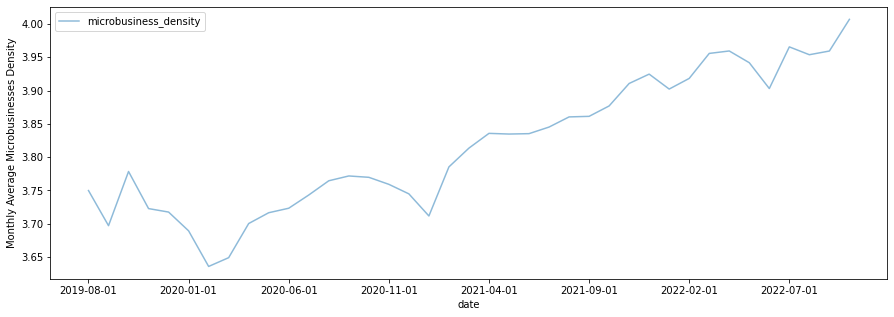

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
average.plot(alpha=0.5, title="", ax=ax)
# trend.plot(linewidth=3, label='trend', color='r', ax=ax)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.grid(False)
ax.legend();
ax.set_ylabel("Monthly Average Microbusinesses Density")
ax.set_xlabel("date")
plt.savefig('averageTrend.png', dpi=300)

# Regression

## The SMAPE performance metric

In [15]:

import numpy as np
  
def SMAPE(target, forecast):
    if not all([isinstance(target, np.ndarray), isinstance(forecast, np.ndarray)]):
        target, forecast = np.array(target), np.array(forecast)
    SAPE = np.abs(target - forecast) / ((np.abs(forecast) + np.abs(target))/2)
    SAPE[np.isnan(SAPE)] = 0  # in the case of target=forecast=0
    return round(np.mean(SAPE), 4)

### Time-Single Linear Model

In [16]:
train

microbusiness_density  active
cfips first_day_of_month                               
1001  2019-08-01                       3.007682    1249
      2019-09-01                       2.884870    1198
      2019-10-01                       3.055843    1269
      2019-11-01                       2.993233    1243
      2019-12-01                       2.993233    1243
...                                         ...     ...
56045 2022-06-01                       1.803249     101
      2022-07-01                       1.803249     101
      2022-08-01                       1.785395     100
      2022-09-01                       1.785395     100
      2022-10-01                       1.785395     100

[122265 rows x 2 columns]

In [17]:
def train_validation_split(x, y, ly=None, validation_size=8):
    n_m = len(x)
    m = validation_size
    n = n_m-m
    x_train = x.iloc[:n]
    x_valid = x.iloc[n:]
    y_train = y.iloc[:n]
    y_valid = y.iloc[n:]
    # print(x_train)
    ly_train = None
    ly_valid = None
    if ly is not None:
        ly_train = ly.iloc[:n]
        ly_valid = ly.iloc[n:]
    return  x_train, x_valid, y_train, y_valid, ly_train, ly_valid, n, n_m
    


In [19]:
# https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/
# !pip install pmdarima
import pmdarima as pm
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import xgboost as XGB
# modelInstance = SARIMAX(exog, order=(1,1,1)).fit(disp=-1)
modelInstance = pm
# order = (0, 2, 0); seasonal_order = (0, 0, 0, 0)
# label = str(order) + str(seasonal_order)
# modelInstance = pm.ARIMA(order=order, seasonal_order = seasonal_order, 
#                         out_of_sample_size = 8, with_intercept = False) 
# modelInstance = LinearRegression()
# modelInstance = XGB.XGBRegressor(random_state=0, n_estimators = 5)
def getModelInstance(x_train, y_train, x_valid=None, y_valid=None):
    MI = modelInstance.auto_arima(y=y_train, #X=x_train, 
                          out_of_sample_size = 8, 
                          max_p= 2, max_d = 2, max_q= 2, #D=1, m=8,
                          max_P= 1, max_D = 1, max_Q= 1, m=6, seasonal=True, 
                          error_action='ignore', 
                          information_criterion='bic')#,  with_intercept = False, n_jobs = 6, stepwise = False, trace=True)
    # MI = MI[0]    
    # print(type(MI))
    # print((MI))
    # print(MI.summary())
    # MI = modelInstance.fit(#X=x_train, 
    #     y=y_train)
    # eMI = y_train - MI.predict(x_train)
    # MI = modelInstance.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], early_stopping_rounds = 2, verbose=0)
    return MI

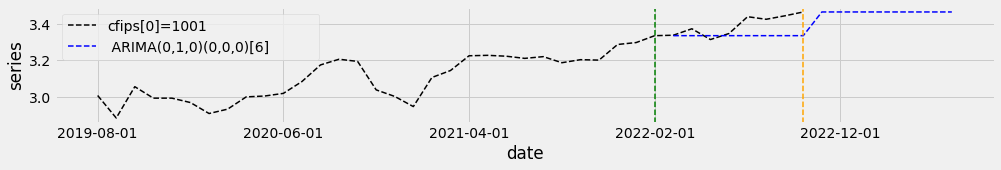

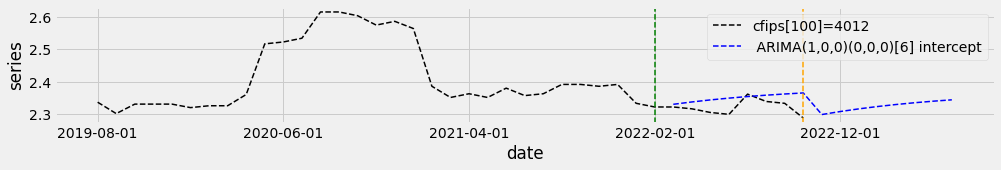

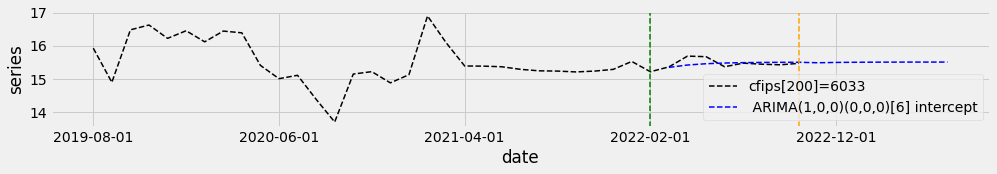

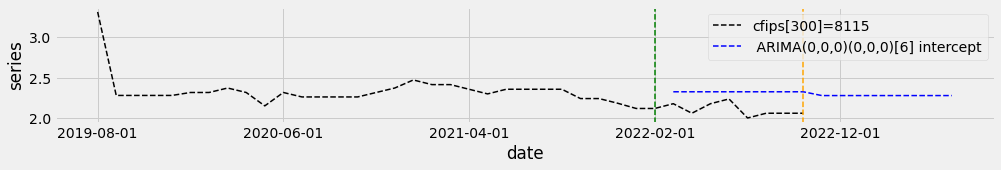

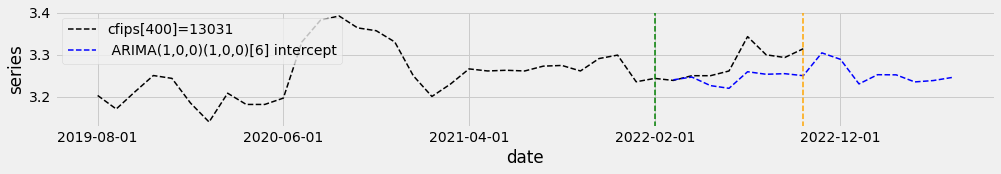

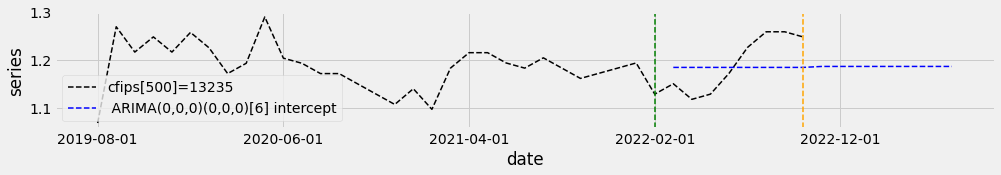

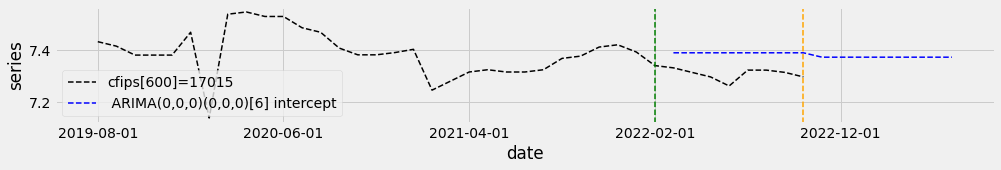

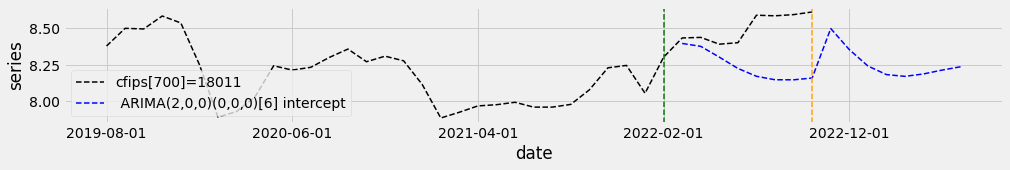

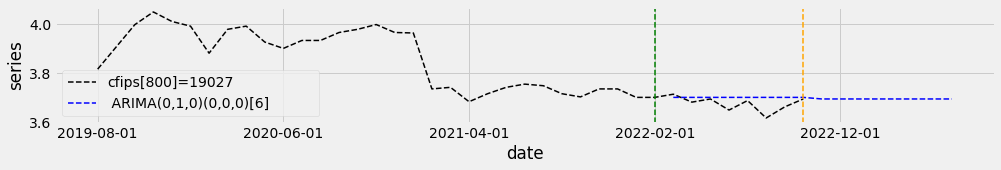

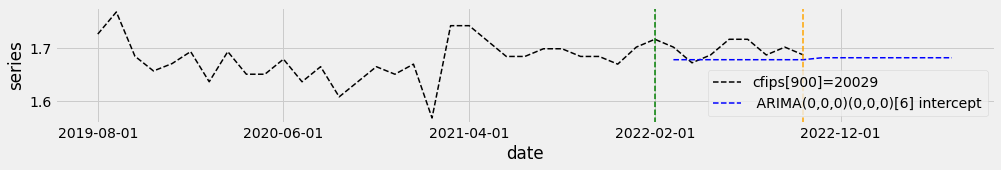

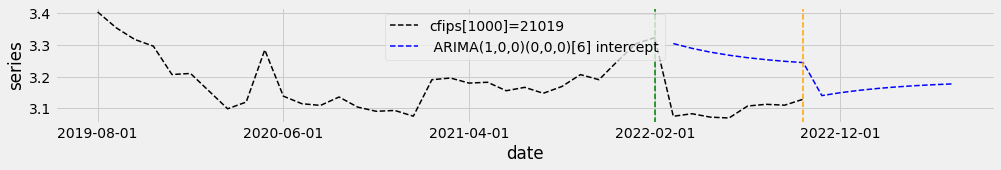

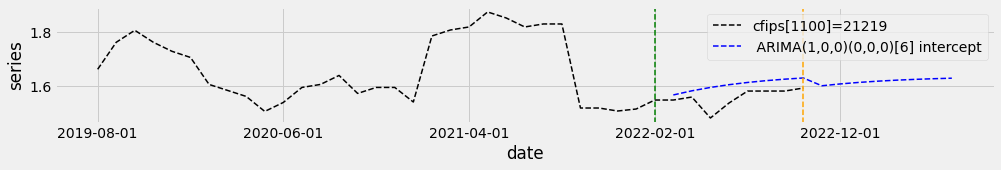

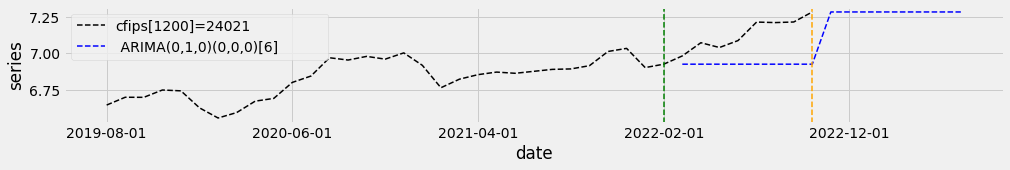

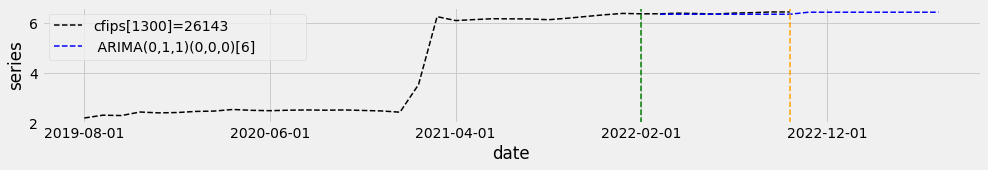

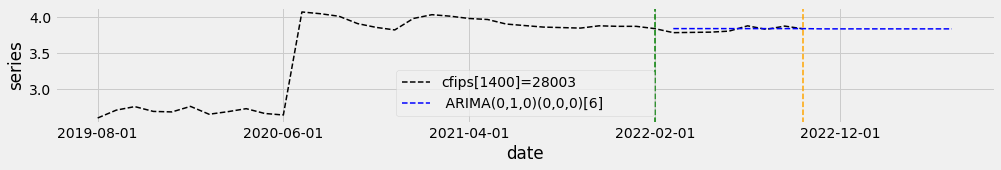

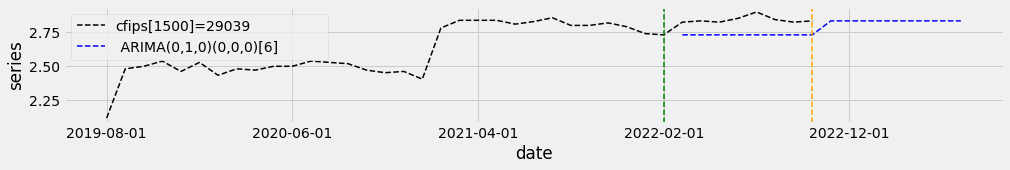

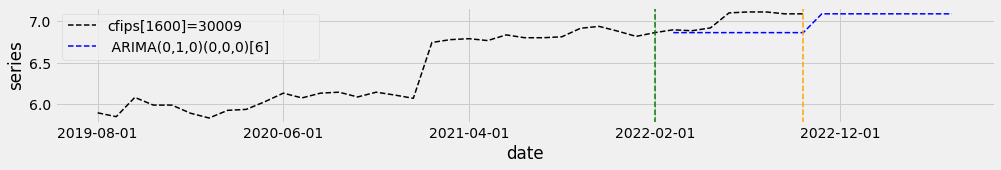

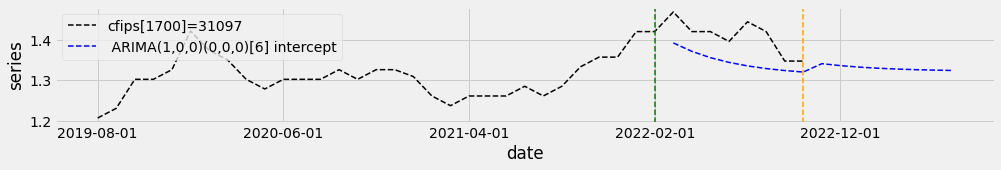

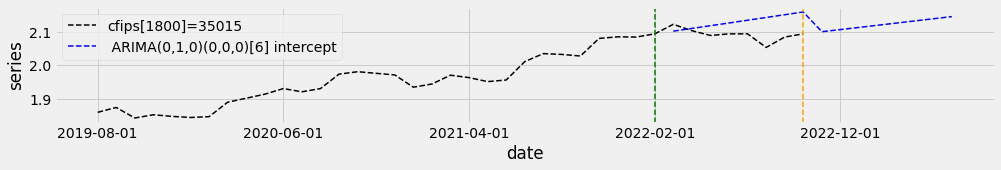

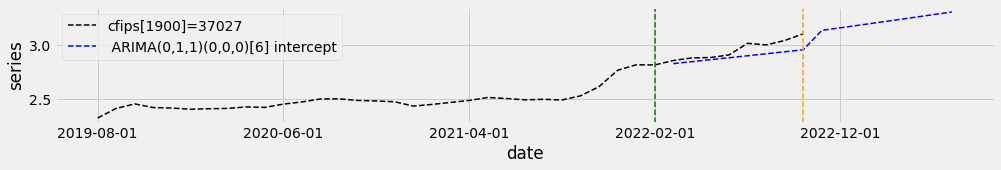

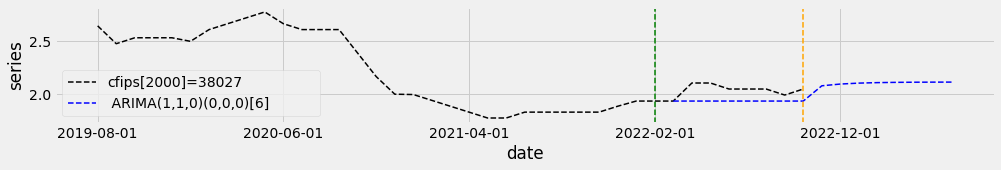

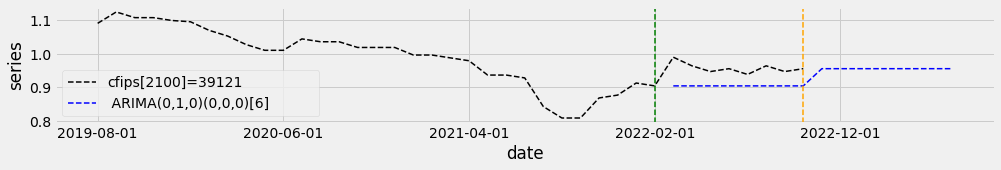

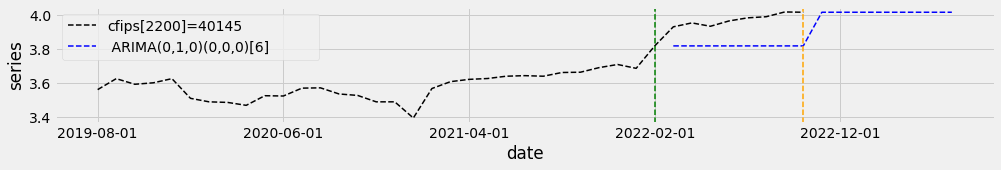

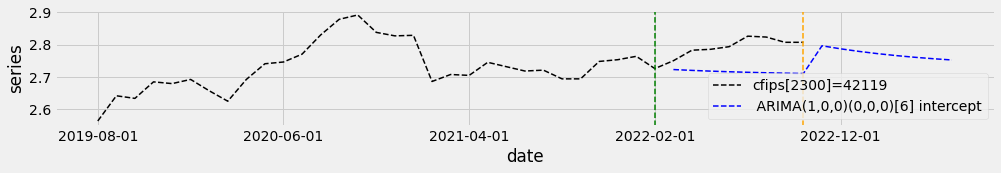

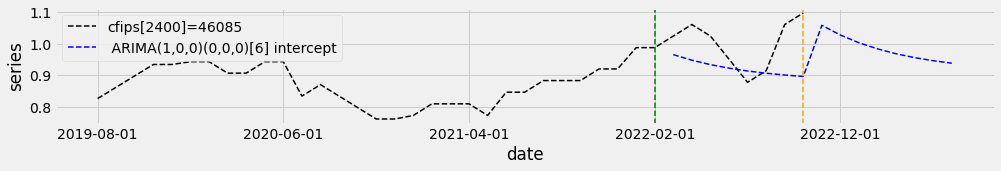

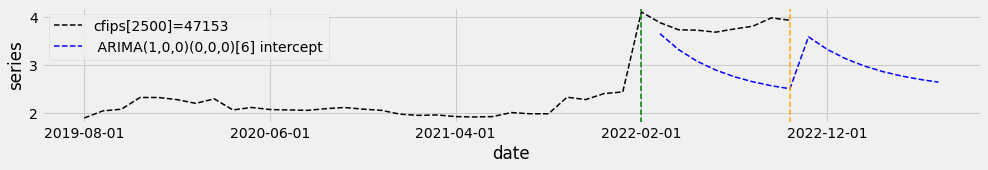

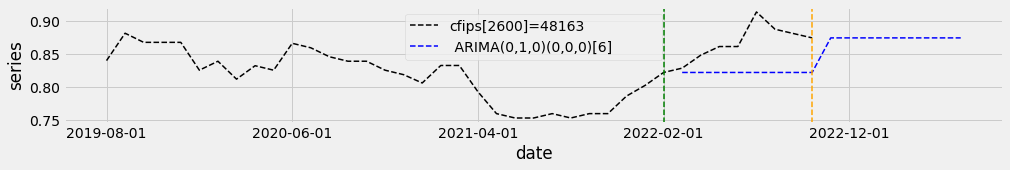

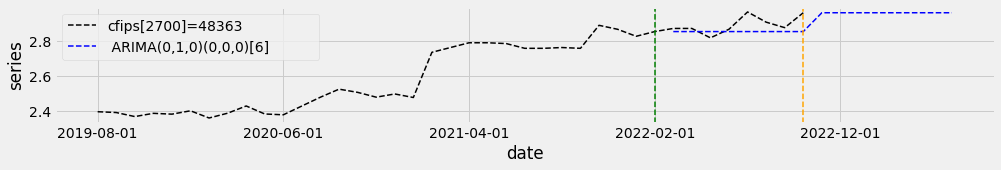

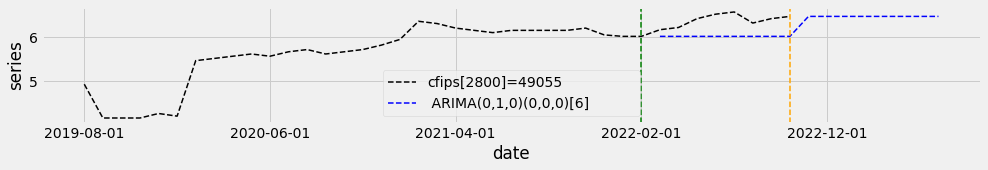

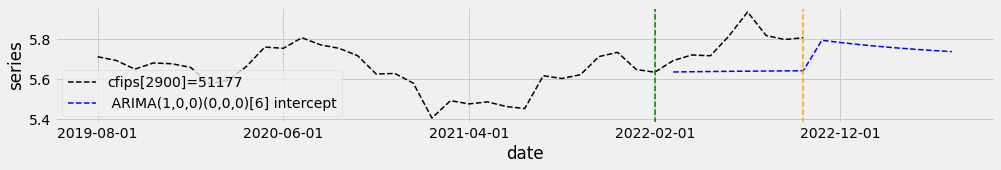

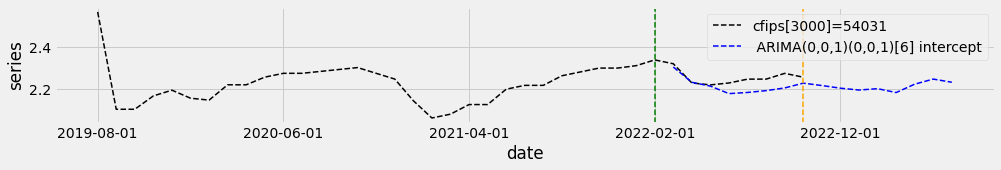

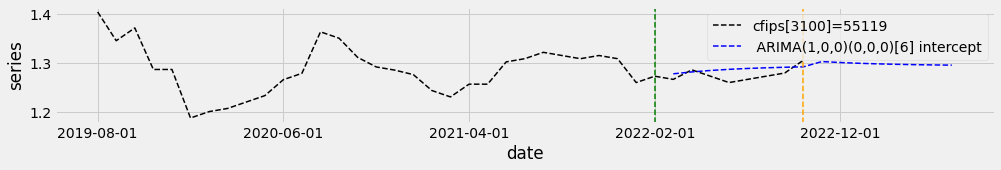

,case,SMAPE_valid,# secs
0,1001,0.0186,2.122204
1,1003,0.0542,1.732486
2,1005,0.0302,2.944929
3,1007,0.0287,7.201252
4,1009,0.0214,1.704317
...,...,...,...
3130,56037,0.0298,3.265830
3131,56039,0.0160,1.645430
3132,56041,0.0139,1.821875
3133,56043,0.0368,1.659682


In [20]:
from sklearn.model_selection import train_test_split
# the desired metric of the competition is the symetric MAPE...
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
row_id = []
microbusiness_density = []
train_performance = []
valid_performance = []
all_performance = []
time_consumption = []
cases = []

with warnings.catch_warnings(record=True):
    for i in range(len(cfipss)):
        start_time = time.time()
        cfips = cfipss[i]
        cases.append(cfips)
        # preprocessing
        df = train.loc[[cfips], :]  # 'microbusiness_density':]#'active'
#         print(df)
        df.reset_index(level=(0), inplace=True)
        df.drop('cfips', inplace=True, axis=1)
        df['t'] = np.arange(len(df.index))
        df['y(t)'] = df['microbusiness_density']  # target
        df['ly(t)'] = np.log1p(df['microbusiness_density'])  # log(1+target)
        # df['ly(t-1)'] = df['ly(t)'].shift(1)
        # df['ly(t-2)'] = df['ly(t)'].shift(2)
        df.fillna(method='backfill', inplace=True)
        # modeling
        x = df.loc[:, ['t']]  # , 'ly(t-1)']]#, 'ly(t-2)']]  # features
        y = df.loc[:, 'y(t)']  # target
        ly = df.loc[:, 'ly(t)']  # target
        m = 8
        x_train, x_valid, y_train, y_valid, ly_train, ly_valid, n, n_m = train_validation_split(
            x, y, ly, validation_size=m)  # train_test_split(x, ly, test_size=m, shuffle=False)
        model = getModelInstance(x_train, ly_train)  # x_valid, ly_valid)
        ly_train_pred = model.arima_res_.forecasts[0]
        # l_residuals_train = np.array(m*[np.mean(ly_train.values[(n-m):] - ly_train_pred[(n-m):])])
        ly_valid_pred = model.predict(n_periods=m  # X = x_valid,
                                      ) #+ l_residuals_train  # my boosting
        y_valid_pred = pd.Series(
            np.expm1(ly_valid_pred), index=x_valid.index).clip(0.0)
        # ly_train_pred = model.predict(n_periods=m, #X = x_train,
        #                                 return_conf_int=False)
        # y_train_pred = pd.Series(np.expm1(ly_train_pred), index=x_train.index).clip(0.0)
        # y_valid_pred = pd.Series(np.expm1(model.predict(x_valid)), index=x_valid.index).clip(0.0)
        # train_performance.append(SMAPE(y_train, y_train_pred))
        valid_performance.append(SMAPE(y_valid, y_valid_pred))
        # model = getModelInstance(x, ly, x_valid, ly_valid)
        # print(model)
        # y_all_pred = pd.Series(np.expm1(model.predict(x)), index=x.index).clip(0.0)
        # all_performance.append(SMAPE(y, y_all_pred))
        #  print('Training SMAPE for cfips=', cfips, ':', SMAPE(y_train, y_train_pred))
        #  print('Validation SMAPE for cfips=', cfips, ':', SMAPE(y_valid, y_valid_pred))

        # Test phase
        testTime = list(range(n_m, n_m+m))  # testTime
        # testLag_1 = x_valid['ly(t-1)'][m-1]; #print(testLag_1)
        x_test = pd.DataFrame({'t': testTime},  # 'ly(t-1)': testLag_1}
                              index=testDates)
        # y_test_pred = []
        # l_residuals_valid =  np.array(m*[np.mean(ly_valid.values - ly_valid_pred)])#ly_valid.values - ly_valid_pred
        model.update(y=ly_valid)  # , X = x_valid
        ly_test_pred = model.predict(n_periods=m,  # X = x_test,
                                     ) #+ l_residuals_valid
        y_test_pred = pd.Series(np.expm1(ly_test_pred),
                                index=x_test.index).clip(0.0)
        # microbusiness_density = list(y_test_pred.values)
        for t in range(m):
            index = testDates[t]
# #             print(index)
#         #     x_test = [pd.Series({'t':testTime[t],'ly(t-1)': testLag_1})]
#             x_test = pd.DataFrame({'t':testTime[t]}#,'ly(t-1)': testLag_1}
#                                 , index = [index])
#             ly_test_pred_t = model.predict(x_test)
#             y_test_pred_t = pd.Series(np.expm1(ly_test_pred_t)).clip(0.0)[0]
#             testLag_1 = ly_test_pred_t
#             y_test_pred.append(y_test_pred_t)
#             #submission file
            row_id.append(str(cfips) + '_' + index)
            microbusiness_density.append(y_test_pred[t])
#         #y_test_pred

        # https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt
        case = 'cfips['+str(i)+']='+str(cfips)
        ts = list(df['microbusiness_density'].values) + m*[np.nan]
        # forecasts_tv = list(y_train_pred.values)  + list(y_valid_pred.values) + m*[np.nan]#y_test_pred
        # list(y_all_pred.values)
        forecasts_all = n*[np.nan] + \
            list(y_valid_pred.values) + list(y_test_pred.values)
        index = dates + testDates
        # (index)
        dfPlot = pd.DataFrame({case: ts,  # 'Forecast_tv': forecasts_tv,
                               str(model): forecasts_all},
                              index=index)
        # dfPlot
        # plotting
        if int(i) % 100 == 0:
            #             print('case index: ', i)
            plt.style.use('fivethirtyeight')
            color_palette = ['black', 'blue', 'red']  # sns.color_palette()
            fig, ax = plt.subplots(figsize=(15, 2))
            dfPlot.plot(ax=ax, color=color_palette[:2], style='--', linewidth=1.5,
                        ylabel='series', xlabel='date')
            ax.axvline(n-1, color='green', ls='--', linewidth=1.5)
            ax.axvline(n_m-1, color='orange', ls='--', linewidth=1.5)
            ax.legend(dfPlot.columns[:2])
            plt.show()
#         print('time expent (seonds): for cfips=', cfips, ':', (time.time() - start_time))
        time_consumption.append((time.time() - start_time))

performance = pd.DataFrame({'case': cases,
                            # 'SMAPE_train': train_performance,
                           'SMAPE_valid': valid_performance,
                            # 'SMAPE_all' : all_performance,
                            '# secs': time_consumption})
performance


In [21]:
performance.describe()

,case,SMAPE_valid,# secs
count,3135.000000,3135.000000,3135.000000
mean,30376.037640,0.043190,2.639015
std,15145.862593,0.065878,1.321488
min,1001.000000,0.000000,0.888544
25%,18178.000000,0.015100,1.785241
50%,29173.000000,0.026400,2.158360
75%,45076.000000,0.047050,2.958579
max,56045.000000,1.333300,10.590871


In [22]:
3135*performance['# secs'].mean()

8273.312988519669

In [23]:
from datetime import datetime
submsision = pd.DataFrame({'row_id':row_id,
'microbusiness_density': microbusiness_density})
now = datetime.today().strftime('%Y%m%d_%H%M%S')
# RESULTS_PATH = "" if isInKaggle else ROOT + "results/microbusinessDensityTS/"
submsision.to_csv(RESULTS_PATH+now+'_'+type(modelInstance).__name__+label+'.csv', index=False)
submsision

NameError: name 'label' is not defined

In [ ]:
now+'_'+type(modelInstance).__name__+label+'.csv'

'20230201_135736_module(0, 2, 0)(0, 0, 0, 0).csv'

In [ ]:
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')
sample_submission.shape

(25080, 2)

In [ ]:
pg = 240*996.40
pg/200000
pg

239136.0